In [181]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
#倒入一些必要的库

In [201]:
feanum=10#一共有多少特征
window=5#时间窗设置
df1=pd.read_excel('data.xlsx',0) #读取数据，0对应第一支股票，1对应第二只，以此类推
df1=df1.iloc[3600:-10,1:11]#选取从第3600行开始的数据 大概是2006年一月
df1.tail()

,开盘,最高,最低,收盘,涨幅,振幅,总手,金额,换手%,成交次数
6920,1630.46,1665.46,1614.20,1656.71,0.036,0.0321,118020026,1472909400,0.608,67052
6921,1690.47,1714.22,1667.96,1689.22,0.0196,0.0279,113695774,1467535000,0.586,60751
6922,1677.96,1747.98,1670.46,1712.97,0.0141,0.0459,107519243,1408651100,0.554,59522
6923,1736.72,1752.98,1715.47,1724.22,0.0066,0.0219,65301888,861618660,0.337,38464
6924,1686.72,1710.47,1675.46,1697.97,-0.0152,0.0203,66173879,852956240,0.341,37324


In [202]:
from sklearn import preprocessing#进行归一化操作
min_max_scaler = preprocessing.MinMaxScaler()
df0=min_max_scaler.fit_transform(df1)
df = pd.DataFrame(df0, columns=df1.columns)
df.tail()

,开盘,最高,最低,收盘,涨幅,振幅,总手,金额,换手%,成交次数
3320,0.707387,0.709322,0.713040,0.721766,0.473203,0.175506,0.228606,0.169598,0.057343,0.262941
3321,0.736287,0.732364,0.739406,0.737461,0.421501,0.152542,0.220065,0.168972,0.054682,0.237921
3322,0.730262,0.748318,0.740632,0.748926,0.404161,0.250957,0.207867,0.162108,0.050811,0.233040
3323,0.758560,0.750680,0.762707,0.754357,0.380517,0.119738,0.124489,0.098344,0.024558,0.149421
3324,0.734481,0.730592,0.743085,0.741685,0.311791,0.110990,0.126211,0.097334,0.025042,0.144894


In [203]:
#技术问题 重新对列做一个排序
order = ['开盘', '最高', '最低', '涨幅','振幅', '总手', '金额','换手%','成交次数','收盘']
df = df[order]
df.tail()

,开盘,最高,最低,涨幅,振幅,总手,金额,换手%,成交次数,收盘
3320,0.707387,0.709322,0.713040,0.473203,0.175506,0.228606,0.169598,0.057343,0.262941,0.721766
3321,0.736287,0.732364,0.739406,0.421501,0.152542,0.220065,0.168972,0.054682,0.237921,0.737461
3322,0.730262,0.748318,0.740632,0.404161,0.250957,0.207867,0.162108,0.050811,0.233040,0.748926
3323,0.758560,0.750680,0.762707,0.380517,0.119738,0.124489,0.098344,0.024558,0.149421,0.754357
3324,0.734481,0.730592,0.743085,0.311791,0.110990,0.126211,0.097334,0.025042,0.144894,0.741685


In [204]:
#这一部分在处理数据 将原始数据改造为LSTM网络的输入
stock=df
seq_len=window
amount_of_features = len(stock.columns)#有几列
data = stock.as_matrix() #pd.DataFrame(stock) 表格转化为矩阵
sequence_length = seq_len + 1#序列长度+1
result = []
for index in range(len(data) - sequence_length):#循环 数据长度-时间窗长度 次
    result.append(data[index: index + sequence_length])#第i行到i+5
result = np.array(result)#得到样本，样本形式为 window*feanum
cut=10#分训练集测试集 最后cut个样本为测试集
train = result[:-cut, :]
x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[-cut:, :-1]
y_test = result[-cut:, -1][:,-1]
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

E:\anoconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [205]:
#展示下训练集测试集的形状 看有没有问题
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (3309, 5, 10)
y_train (3309,)
X_test (10, 5, 10)
y_test (10,)


In [206]:
#建立、训练模型过程
d = 0.0001
model = Sequential()#建立层次模型
model.add(LSTM(64, input_shape=(window, feanum), return_sequences=True))#建立LSTM层
model.add(Dropout(d))#建立的遗忘层
model.add(LSTM(16, input_shape=(window, feanum), return_sequences=False))#建立LSTM层
model.add(Dropout(d))#建立的遗忘层
model.add(Dense(4,init='uniform',activation='relu'))   #建立全连接层     
model.add(Dense(1,init='uniform',activation='relu'))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.fit(X_train, y_train, nb_epoch =100, batch_size = 256) #训练模型nb_epoch次

E:\anoconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_initializer="uniform", activation="relu")`
  
E:\anoconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform", activation="relu")`
  if __name__ == '__main__':
E:\anoconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/100
3309/3309 [==============================] - 7s 2ms/step - loss: 0.2108 - acc: 3.0221e-04
Epoch 2/100
3309/3309 [==============================] - 1s 267us/step - loss: 0.1982 - acc: 3.0221e-04
Epoch 3/100
3309/3309 [==============================] - 1s 276us/step - loss: 0.1757 - acc: 3.0221e-04
Epoch 4/100
3309/3309 [==============================] - 1s 272us/step - loss: 0.1266 - acc: 3.0221e-04
Epoch 5/100
3309/3309 [==============================] - 1s 262us/step - loss: 0.0672 - acc: 3.0221e-04
Epoch 6/100
3309/3309 [==============================] - 1s 269us/step - loss: 0.0449 - acc: 3.0221e-04
Epoch 7/100
3309/3309 [==============================] - 1s 261us/step - loss: 0.0418 - acc: 3.0221e-04
Epoch 8/100
3309/3309 [==============================] - 1s 263us/step - loss: 0.0316 - acc: 3.0221e-04
Epoch 9/100
3309/3309 [==============================] - 1s 265us/step - loss: 0.0194 - acc: 3.0221e-04
Epoch 10/100
3309/3309 [==============================] - 1s 262us

3309/3309 [==============================] - 1s 331us/step - loss: 2.2399e-04 - acc: 6.0441e-04
Epoch 77/100
3309/3309 [==============================] - 1s 323us/step - loss: 2.1008e-04 - acc: 6.0441e-04
Epoch 78/100
3309/3309 [==============================] - 1s 274us/step - loss: 2.2639e-04 - acc: 6.0441e-04
Epoch 79/100
3309/3309 [==============================] - 1s 266us/step - loss: 2.3928e-04 - acc: 6.0441e-04
Epoch 80/100
3309/3309 [==============================] - 1s 287us/step - loss: 2.1015e-04 - acc: 6.0441e-04
Epoch 81/100
3309/3309 [==============================] - 1s 268us/step - loss: 2.0607e-04 - acc: 6.0441e-04
Epoch 82/100
3309/3309 [==============================] - 1s 264us/step - loss: 2.0455e-04 - acc: 6.0441e-04
Epoch 83/100
3309/3309 [==============================] - 1s 271us/step - loss: 2.2806e-04 - acc: 6.0441e-04
Epoch 84/100
3309/3309 [==============================] - 1s 285us/step - loss: 2.1023e-04 - acc: 6.0441e-04
Epoch 85/100
3309/3309 [========

In [207]:
#总结模型
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 5, 64)             19200     
_________________________________________________________________
dropout_43 (Dropout)         (None, 5, 64)             0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 16)                5184      
_________________________________________________________________
dropout_44 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 5         
Total params: 24,457
Trainable params: 24,457
Non-trainable params: 0
_________________________________________________________________


In [208]:
#在训练集上的拟合结果
y_train_predict=model.predict(X_train)[:,0]
y_train=y_train

Text(0.5,1,'Train Data')

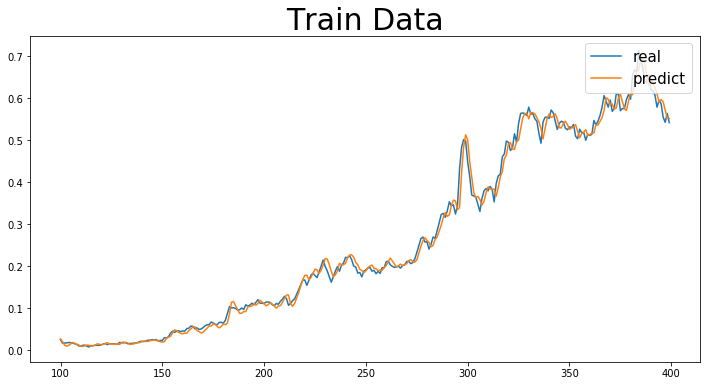

In [209]:
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
draw.iloc[100:400,0].plot(figsize=(12,6))
draw.iloc[100:400,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题
#展示在训练集上的表现 

In [210]:
#在测试集上的预测
y_test_predict=model.predict(X_test)[:,0]
y_test=y_test

Text(0.5,1,'Test Data')

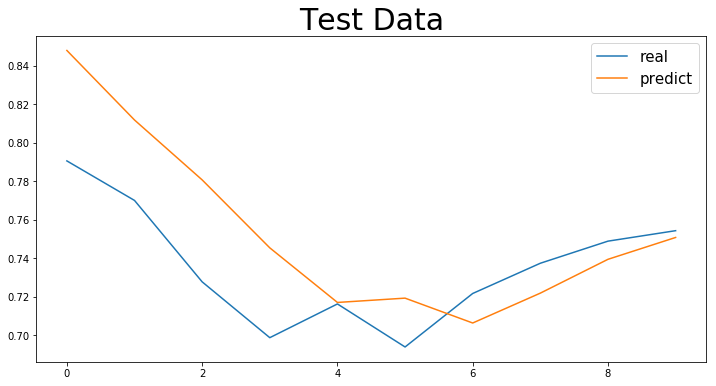

In [211]:
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
draw.iloc[:,0].plot(figsize=(12,6))
draw.iloc[:,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题
#展示在测试集上的表现 

In [212]:
#输出结果
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
print('训练集上的MAE/MSE/MAPE')
print(mean_absolute_error(y_train_predict, y_train))
print(mean_squared_error(y_train_predict, y_train) )
print(mape(y_train_predict, y_train) )
print('测试集上的MAE/MSE/MAPE')
print(mean_absolute_error(y_test_predict, y_test))
print(mean_squared_error(y_test_predict, y_test) )
print(mape(y_test_predict, y_test) )
y_var_test=y_test[1:]-y_test[:len(y_test)-1]
y_var_predict=y_test_predict[1:]-y_test_predict[:len(y_test_predict)-1]
txt=np.zeros(len(y_var_test))
for i in range(len(y_var_test-1)):
    txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
result=sum(txt)/len(txt)
print('预测涨跌正确:',result)

训练集上的MAE/MSE/MAPE
0.009782991276097091
0.00020189546823013484
4.007854644751634
测试集上的MAE/MSE/MAPE
0.026848849524051886
0.0011220225176337844
3.462527965648396
预测涨跌正确: 0.6666666666666666
